# Get the data

In [2]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math
!pip install catboost
%matplotlib inline

In [3]:
## Load the bankruptcy_helper module

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 

# Import bankruptcy_helper module
import bankruptcy_helper
%aimport bankruptcy_helper

helper = bankruptcy_helper.Helper()

In [4]:
# Data directory
DATA_DIR = "./Data"

if not os.path.isdir(DATA_DIR):
    DATA_DIR = "../resource/asnlib/publicdata/bankruptcy/data"

data_file = "5th_yr.csv"
data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file) )

target_attr = "Bankrupt"

n_samples, n_attrs = data.shape
print("Date shape: ", data.shape)

Date shape:  (4818, 66)


# Exploratory Data Analysis

1. The code converts all columns in the dataset to numeric values, replacing any invalid or non-numeric entries (like strings) with `NaN`. This is useful to ensure that all data is in a consistent numeric format for further analysis. After conversion, the first few rows of the dataset are displayed to verify the changes.

In [5]:
data = data.apply(pd.to_numeric, errors='coerce')
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0,0.025417,0.417690,0.05680,1.1605,-126.390,0.413550,0.025417,1.23950,1.16500,0.51773,...,0.049094,0.85835,0.123220,5.6167,7.4042,164.310,2.2214,1.3340,0,4510
1,-0.023834,0.210100,0.50839,4.2374,22.034,0.058412,-0.027621,3.65790,0.98183,0.76855,...,-0.031011,1.01850,0.069047,5.7996,7.7529,26.446,13.8020,6.4782,0,3537
2,0.030515,0.446060,0.19569,1.5650,35.766,0.281960,0.039264,0.88456,1.05260,0.39457,...,0.077337,0.95006,0.252660,15.0490,2.8179,104.730,3.4852,2.6361,0,3920
3,0.052318,0.056366,0.54562,10.6800,438.200,0.136490,0.058164,10.85300,1.02790,0.61173,...,0.085524,0.97282,0.000000,6.0157,7.4626,48.756,7.4863,1.0602,0,1806
4,0.000992,0.497120,0.12316,1.3036,-71.398,0.000000,0.001007,1.01160,1.29210,0.50288,...,0.001974,0.99925,0.019736,3.4819,8.5820,114.580,3.1854,2.7420,0,1529


2. The following code visualizes the data to better understand feature relationships, distributions, and potential patterns before model building.

<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

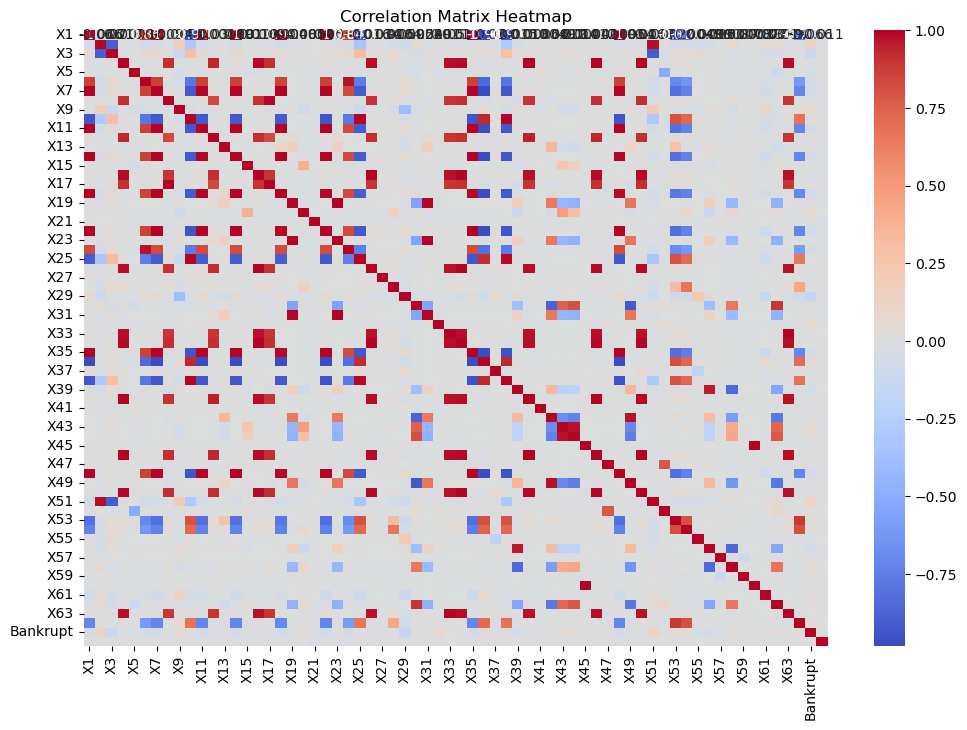

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()


The heatmap above visualizes the correlation matrix of the features in the dataset. Each cell in the matrix represents the correlation coefficient between two features. The color scale ranges from -1 to 1, with red indicating a positive correlation and blue representing a negative correlation. The diagonal from the top left to the bottom right shows a perfect correlation of 1, as each feature is perfectly correlated with itself. Some features exhibit relatively strong correlations, either positive or negative, while others show weak or no correlation. This heatmap helps in identifying multicollinearity issues, where certain features are highly correlated, and assists in determining which features might be redundant or provide overlapping information. It also shows the correlation between the features and the target variable "Bankrupt," which helps in understanding which features might have a stronger influence on the prediction task.

array([[<Axes: title={'center': 'X1'}>, <Axes: title={'center': 'X2'}>,
        <Axes: title={'center': 'X3'}>, <Axes: title={'center': 'X4'}>,
        <Axes: title={'center': 'X5'}>, <Axes: title={'center': 'X6'}>,
        <Axes: title={'center': 'X7'}>, <Axes: title={'center': 'X8'}>],
       [<Axes: title={'center': 'X9'}>, <Axes: title={'center': 'X10'}>,
        <Axes: title={'center': 'X11'}>, <Axes: title={'center': 'X12'}>,
        <Axes: title={'center': 'X13'}>, <Axes: title={'center': 'X14'}>,
        <Axes: title={'center': 'X15'}>, <Axes: title={'center': 'X16'}>],
       [<Axes: title={'center': 'X17'}>, <Axes: title={'center': 'X18'}>,
        <Axes: title={'center': 'X19'}>, <Axes: title={'center': 'X20'}>,
        <Axes: title={'center': 'X21'}>, <Axes: title={'center': 'X22'}>,
        <Axes: title={'center': 'X23'}>, <Axes: title={'center': 'X24'}>],
       [<Axes: title={'center': 'X25'}>, <Axes: title={'center': 'X26'}>,
        <Axes: title={'center': 'X27'}>, <Ax

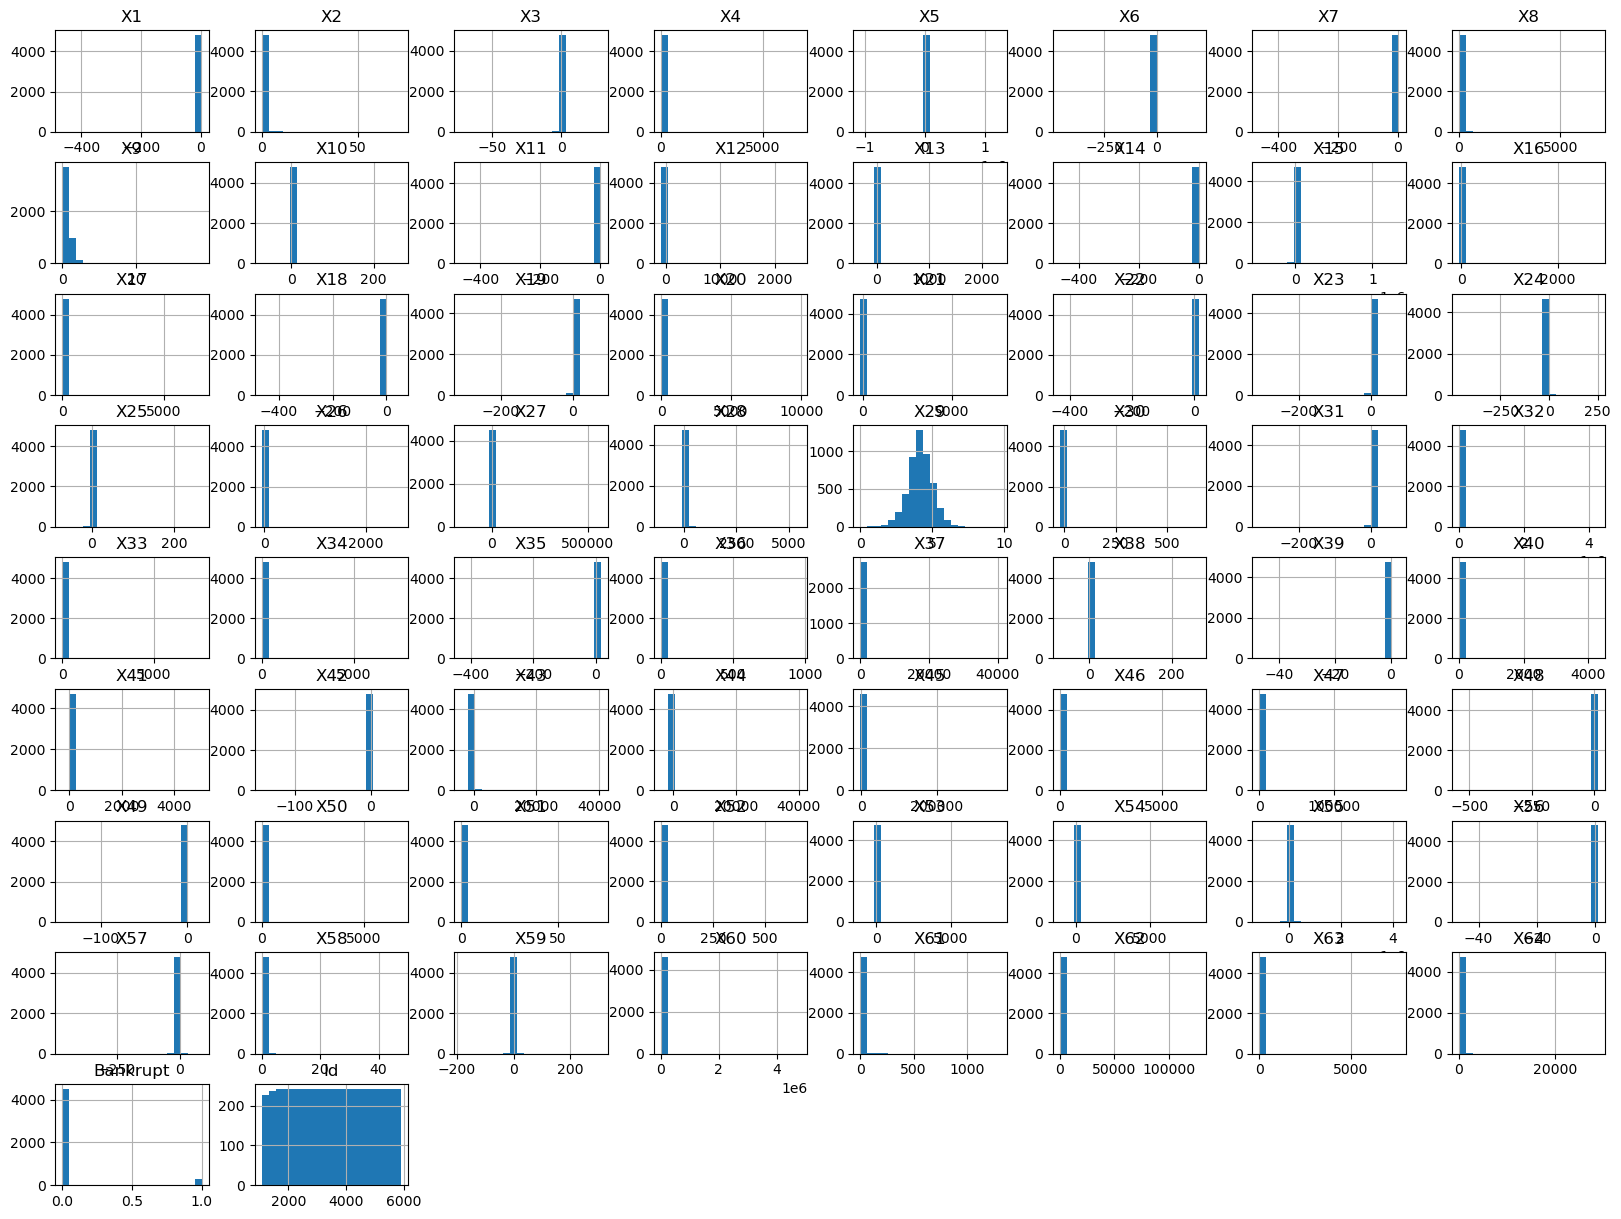

In [7]:
data.hist(bins=20, figsize=(20, 15))
plt.show()


The grid of histograms above visualizes the distribution of each feature in the dataset. Each plot represents one feature, showing the frequency distribution of its values. It is evident that many features exhibit a skewed distribution, with a large concentration of values around zero, while a few features display more variance, such as X37, which has a more normal-like distribution. This suggests that several features might have outliers or highly imbalanced distributions, which could influence the model performance. Additionally, the target variable "Bankrupt" at the bottom left shows the class imbalance, as there are significantly more non-bankrupt instances than bankrupt ones, highlighting the need for techniques such as SMOTE to handle this imbalance during model training.

<Figure size 1500x1000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Boxplot of All Features')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),
 [Text(0, 0, 'X1'),
  Text(1, 0, 'X2'),
  Text(2, 0, 'X3'),
  Text(3, 0, 'X4'),
  Text(4, 0, 'X5'),
  Text(5, 0, 'X6'),
  Text(6, 0, 'X7'),
  Text(7, 0, 'X8'),
  Text(8, 0, 'X9'),
  Text(9, 0, 'X10'),
  Text(10, 0, 'X11'),
  Text(11, 0, 'X12'),
  Text(12, 0, 'X13'),
  Text(13, 0, 'X14'),
  Text(14, 0, 'X15'),
  Text(15, 0, 'X16'),
  Text(16, 0, 'X17'),
  Text(17, 0, 'X18'),
  Text(18, 0, 'X19'),
  Text(19, 0, 'X20'),
  Text(20, 0, 'X21'),
  Text(21, 0, 'X22'),
  Text(22, 0, 'X23'),
  Text(23, 0, 'X24'),
  Text(24, 0, 'X25'),
  Text(25, 0, 'X26'),
  Text(26, 0, 'X27'),
  Text(27, 0, 'X28'),
  Text(28, 0, 'X29'),
  Text(29, 0, 'X30'),
  Text(30, 0, 'X31'),
  Text(31, 0, 'X32'),
  Text(32, 0, 'X3

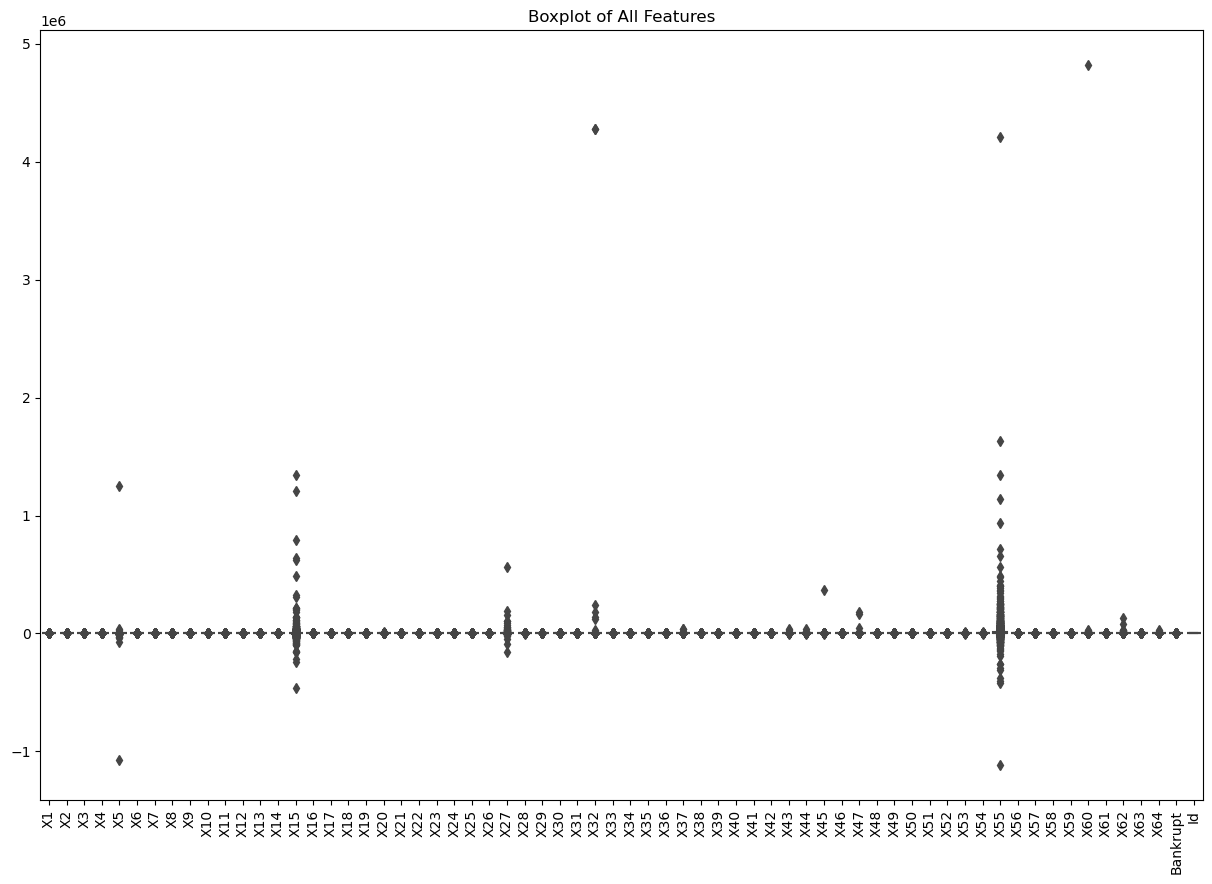

In [8]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=data)
plt.title('Boxplot of All Features')
plt.xticks(rotation=90)
plt.show()


The boxplot above visualizes the distribution of all features in the dataset, providing insights into the presence of outliers. Each feature is represented along the x-axis, while the y-axis displays the range of values for these features. As observed, many features show tightly clustered values near zero, but there are several extreme outliers in the dataset, such as in features X13, X15, X55, and a few others. These outliers may need to be addressed or handled in the modeling process, as they could significantly influence the model's performance if left untreated.

c:\Users\mini\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mini\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mini\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mini\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

c:\Users\mini\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


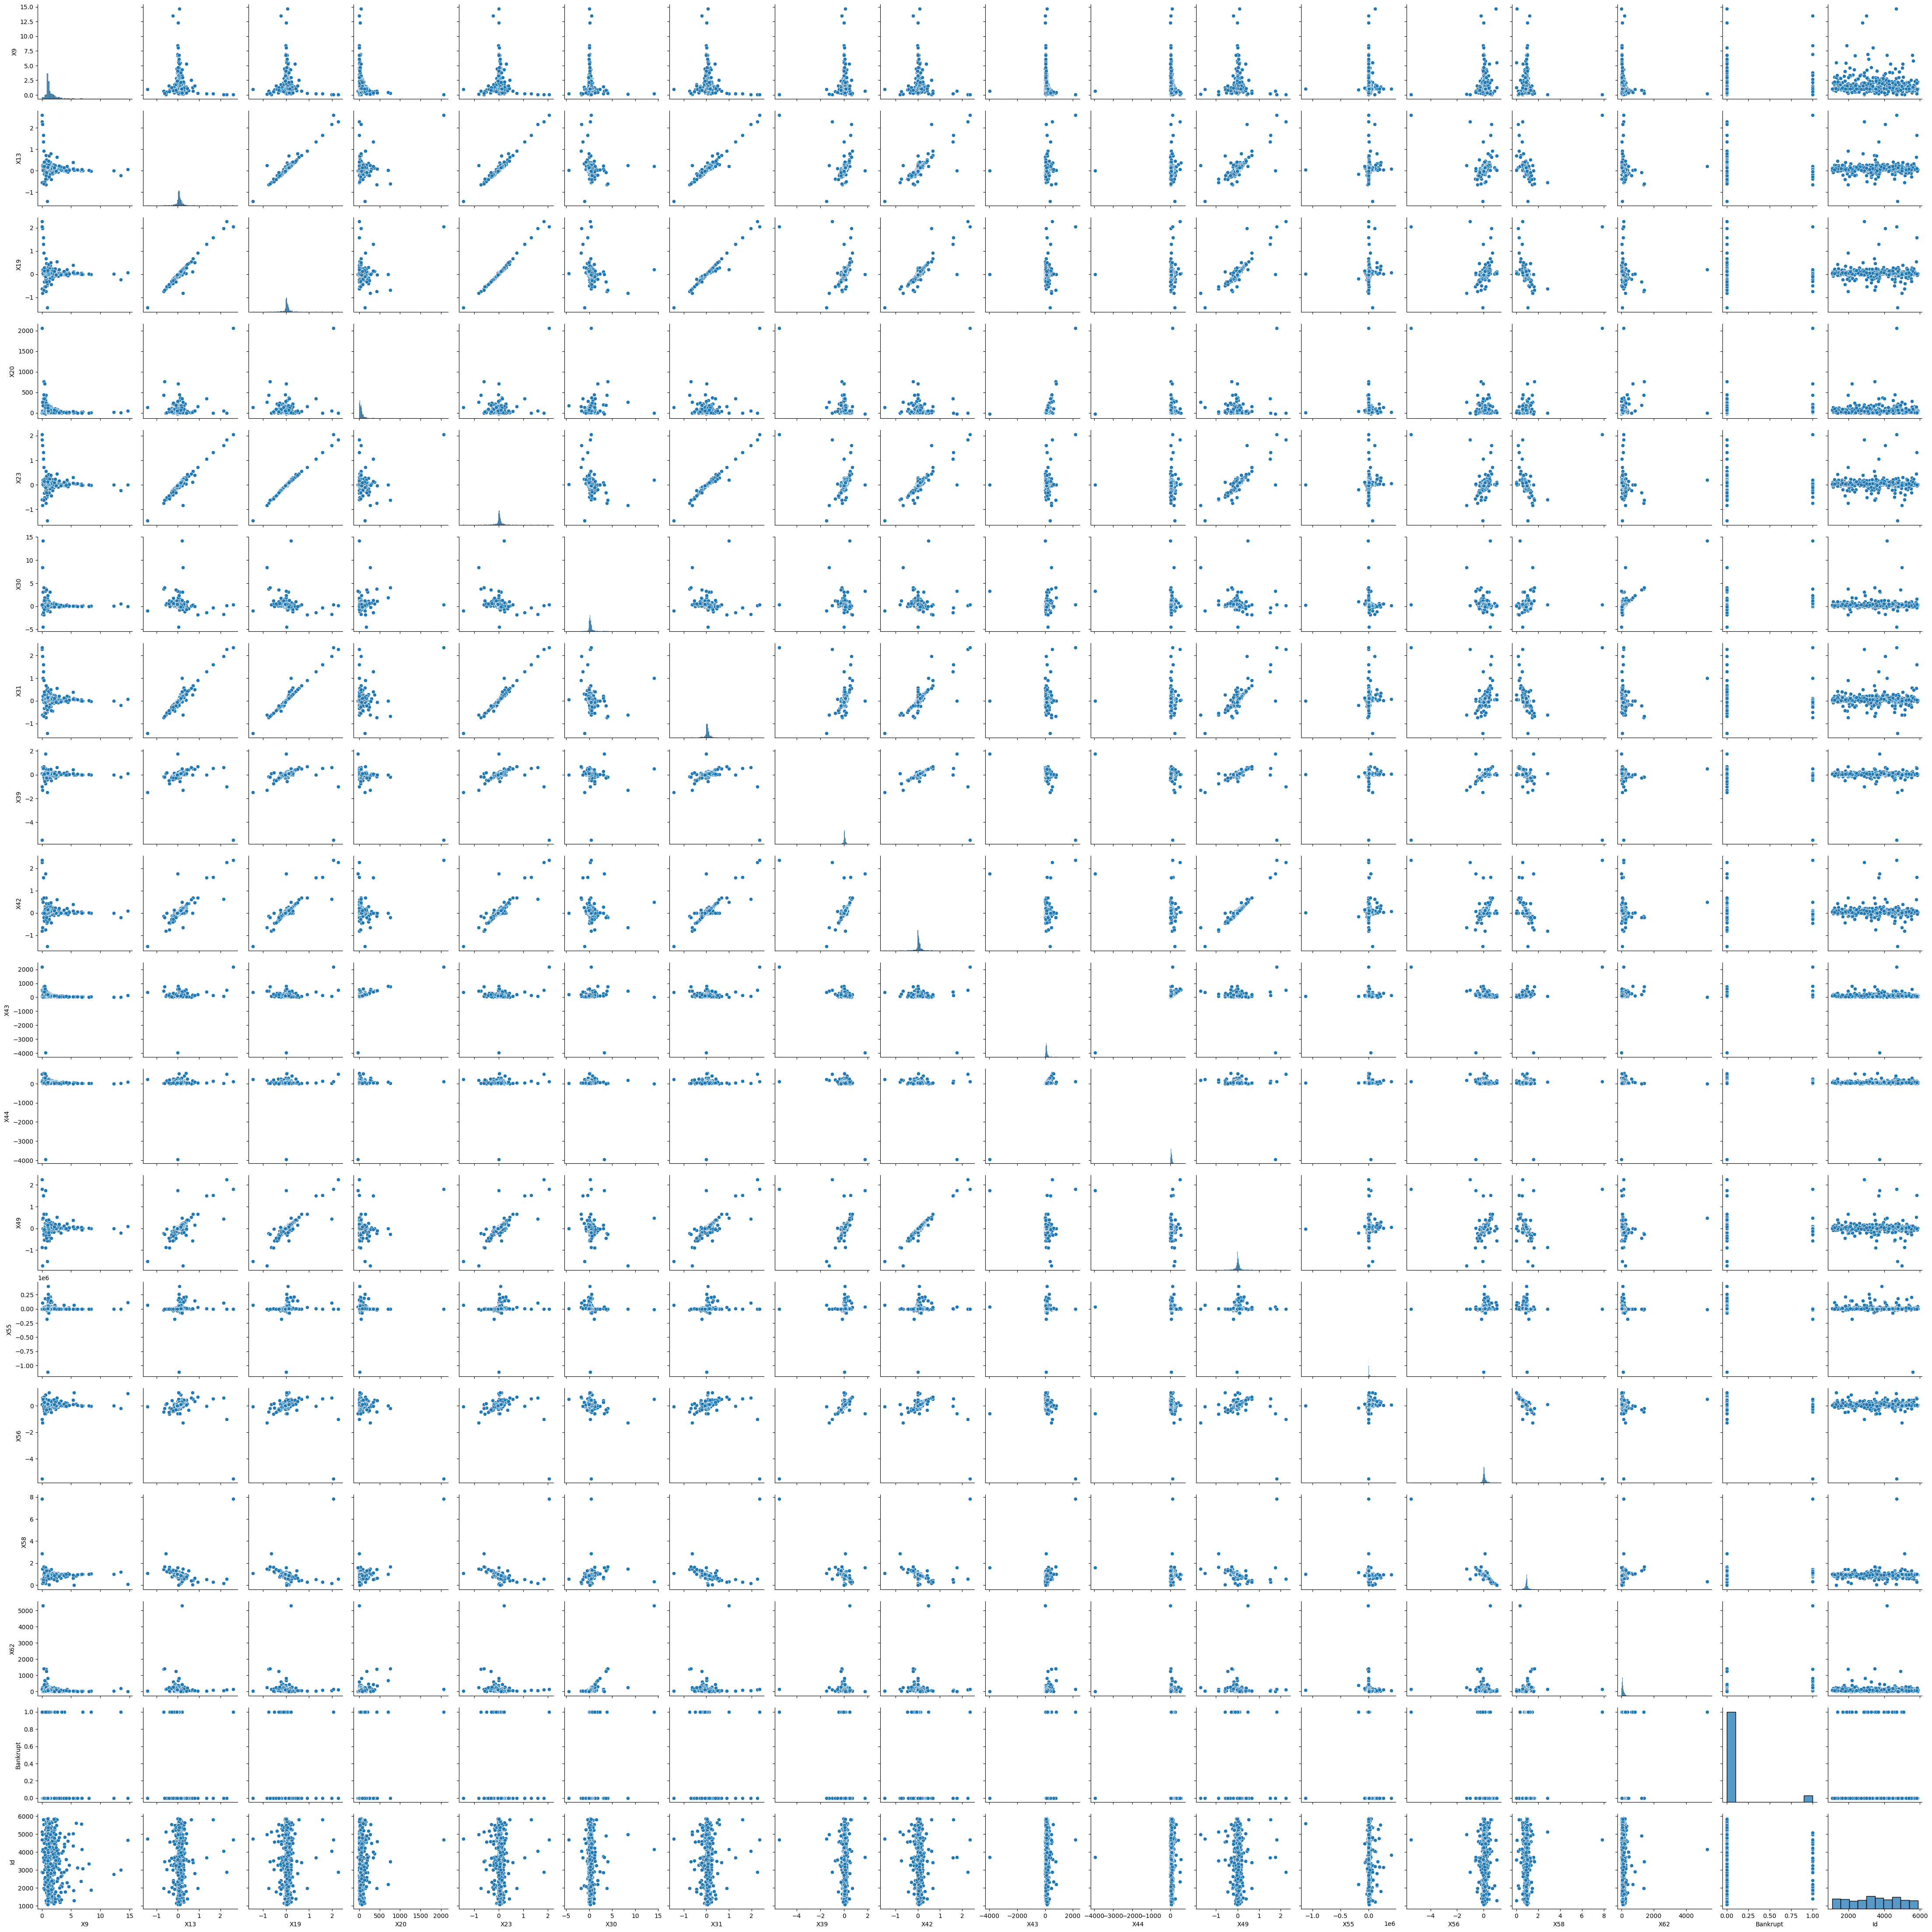

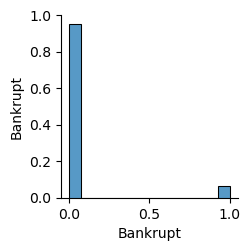

In [7]:
sampled_data = data.sample(frac=0.1, random_state=42)  # Use 10% of the data
sns.pairplot(sampled_data)
sns.pairplot(data[['X1', 'X2', 'X3', 'Bankrupt']])


The pair plots generated provide an in-depth exploration of the pairwise relationships between different features in the dataset, as well as their distributions. Each diagonal element represents the distribution of a single variable, while the other scatter plots reveal the correlation and interaction between pairs of features. This type of visualization helps in identifying potential patterns, relationships, and outliers among the features, which could be useful for model building and understanding the underlying structure of the data. However, due to the high number of features, the plots may be dense, and further focused analysis might be needed on key feature subsets.

3. This part of the code provides a summary of the dataset, including the data types, missing values, and statistical summary to help understand the structure and contents of the data before further analysis.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4816 non-null   float64
 1   X2        4816 non-null   float64
 2   X3        4816 non-null   float64
 3   X4        4803 non-null   float64
 4   X5        4808 non-null   float64
 5   X6        4816 non-null   float64
 6   X7        4816 non-null   float64
 7   X8        4804 non-null   float64
 8   X9        4818 non-null   float64
 9   X10       4816 non-null   float64
 10  X11       4816 non-null   float64
 11  X12       4803 non-null   float64
 12  X13       4818 non-null   float64
 13  X14       4816 non-null   float64
 14  X15       4812 non-null   float64
 15  X16       4804 non-null   float64
 16  X17       4804 non-null   float64
 17  X18       4816 non-null   float64
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4744 non-null   floa

In [10]:
data.describe()


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
count,4816.000000,4816.000000,4816.000000,4803.000000,4.808000e+03,4816.000000,4816.000000,4804.000000,4818.000000,4816.000000,...,4816.000000,4818.000000,4816.000000,4.598000e+03,4806.000000,4818.000000,4803.000000,4735.000000,4818.000000,4818.000000
mean,-0.055232,0.533272,0.188992,4.978602,1.956441e+01,-0.070060,-0.042516,5.739985,1.579277,0.503606,...,0.022793,0.959585,0.273025,1.108795e+03,11.021303,177.494445,9.287631,38.557533,0.063927,3499.858032
std,6.707351,1.202909,1.282430,100.273952,2.384491e+04,7.778523,6.707970,109.508001,1.342723,4.044036,...,7.249022,0.932427,6.338601,7.106563e+04,43.821146,2279.713700,113.225922,588.711967,0.244648,1392.049260
min,-463.890000,0.000000,-72.067000,0.000000,-1.076400e+06,-463.890000,-463.890000,-3.735100,0.000191,-71.444000,...,-468.670000,-0.085920,-184.980000,-1.244000e+01,-0.092493,0.000000,0.000000,-3.726500,0.000000,1071.000000
25%,0.004047,0.254670,0.044923,1.099200,-4.312000e+01,0.000000,0.005985,0.481588,1.015600,0.318990,...,0.015574,0.876940,0.000000,5.298300e+00,4.229925,45.065750,3.074350,2.114850,0.000000,2296.250000
50%,0.046487,0.451495,0.218560,1.642300,3.673450e-01,0.000000,0.056685,1.149000,1.140500,0.522325,...,0.108940,0.950825,0.006320,9.038900e+00,6.176800,73.879500,4.928700,4.077200,0.000000,3500.500000
75%,0.116730,0.662177,0.420152,2.929200,4.986775e+01,0.110470,0.136025,2.781300,1.814050,0.721823,...,0.240262,0.990358,0.206915,1.720750e+01,9.302800,118.597500,8.067850,9.187600,0.000000,4704.750000
max,2.352300,72.416000,28.336000,6845.800000,1.250100e+06,203.150000,2.352300,6868.500000,37.807000,266.860000,...,87.981000,47.788000,308.150000,4.818700e+06,1308.500000,127450.000000,7641.300000,28999.000000,1.000000,5909.000000


# Train the Model

## Framework

-  Initial Attempt - Basic CatBoost Model
    - Started with the basic CatBoost model, trained it, and observed its initial performance. Given the promising results, decided to explore this model further.

-  Hyperparameter Tuning - GridSearch with Recall as Scoring Metric
    - Used GridSearch for hyperparameter tuning on the CatBoost model, selecting Recall as the scoring metric to focus on improving the model's ability to identify positive cases.

-  Hyperparameter Tuning - GridSearch with F-beta as Scoring Metric
    - After optimizing for Recall, shifted the scoring metric to F-beta to balance between Recall and Precision, aiming for a more comprehensive model performance.

-  Expanded GridSearch Hyperparameter Tuning Range
    - Expanded the search space in GridSearch, including parameters like depth, learning rate, and iterations, to explore various combinations and further optimize the model's performance.

-  Tried XGBoost Model
    - In addition to CatBoost, experimented with the XGBoost model. Applied GridSearch for hyperparameter optimization and compared its performance with CatBoost.

-  Optimized with RandomizedSearchCV
    - Applied RandomizedSearchCV for both CatBoost and XGBoost models to enhance the efficiency of hyperparameter tuning, allowing for a broader exploration of parameter combinations.

-  Tried Stacking (CatBoost + XGBoost) - Logistic Regression as the Meta-Model
    - Built a Stacking model using CatBoost and XGBoost as base learners, with Logistic Regression as the second-layer meta-model, aiming to improve predictive performance by combining multiple models.

-  Stacking + RandomizedSearchCV - Optimized Logistic Regression Meta-Model
    - Applied RandomizedSearchCV to optimize the first layer of the Stacking model (CatBoost and XGBoost), tuning both models separately, and selected the best-performing Stacking model for final predictions and evaluation.



**Initial Attempt - Basic CatBoost Model:**

In [11]:
from sklearn.model_selection import train_test_split  # Import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Assume you have already prepared your data (containing features X and label y)
X = data.drop(['Bankrupt', 'Id'], axis=1)  # Drop 'Bankrupt' and 'Id' columns
X.fillna(X.median(), inplace=True)  # Fill missing values with column medians
y = data['Bankrupt']  # Set the 'Bankrupt' label as the target variable (y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Use a Pipeline that includes StandardScaler and CatBoost
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('catboost', CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=100, class_weights=[1, 5]))  # Set class weights to balance classes
])

# Train the model
pipeline.fit(X_train_res, y_train_res)

# Make predictions using the trained model
y_pred = pipeline.predict(X_test)

# Calculate accuracy, recall, and precision
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Print all metrics
print(f"Model Accuracy: {accuracy:.4f}")
print(f"Model Recall: {recall:.4f}")
print(f"Model Precision: {precision:.4f}")


0:	learn: 0.6066636	total: 169ms	remaining: 2m 48s
100:	learn: 0.0849256	total: 1.36s	remaining: 12.1s
200:	learn: 0.0390674	total: 2.9s	remaining: 11.5s
300:	learn: 0.0237787	total: 4.28s	remaining: 9.93s
400:	learn: 0.0185018	total: 5.32s	remaining: 7.95s
500:	learn: 0.0152497	total: 6.39s	remaining: 6.36s
600:	learn: 0.0130382	total: 7.39s	remaining: 4.9s
700:	learn: 0.0119646	total: 8.32s	remaining: 3.55s
800:	learn: 0.0114031	total: 9.36s	remaining: 2.33s
900:	learn: 0.0103182	total: 10.3s	remaining: 1.13s
999:	learn: 0.0099968	total: 11.2s	remaining: 0us


Pipeline(steps=[('scaler', StandardScaler()),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x00000207633DB3D0>)])

Model Accuracy: 0.9315
Model Recall: 0.6429
Model Precision: 0.5233


**Explanation:** The Accuracy is relatively high, however, according to the situation this classification model is used, I want to further improve recall. So next step, I tried using Hyperparameter tuning and set recall as score.

**Catboost has obtained considerable results, so it starts to explore this model in detail, and adopts GridSearch Hyperparameter tuning -Recall as the scoring standard:**

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, fbeta_score, make_scorer, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

# Prepare the data
X = data.drop(['Bankrupt', 'Id'], axis=1)  # Remove 'Bankrupt' and 'Id' columns
X.fillna(X.median(), inplace=True)  # Fill missing values with the median
y = data['Bankrupt']  # Use 'Bankrupt' as the target label (y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Define a pipeline with StandardScaler and CatBoost classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Preprocessing: Standardize features
    ('catboost', CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=100, class_weights=[1, 5]))  # Set class weights for imbalance
])

# Perform hyperparameter tuning (you can adjust more options as needed)
param_grid = {
    'catboost__depth': [6, 8],  # You can add more options
    'catboost__learning_rate': [0.01, 0.1],
    'catboost__iterations': [500, 1000]
}

# Use GridSearch to optimize the parameters, with Recall as the scoring metric
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='recall', verbose=1)
grid_search.fit(X_train, y_train)

# After finding the best model, make predictions
y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  # Get the probability for the positive class

# Adjust the threshold (you can try different thresholds, e.g., 0.3)
threshold = 0.3
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Evaluate the model's Recall and Precision
recall_adjusted = recall_score(y_test, y_pred_adjusted)
precision_adjusted = precision_score(y_test, y_pred_adjusted)

# Output results
print(f"Best params: {grid_search.best_params_}")
print(f"Adjusted Model Recall: {recall_adjusted:.4f}")
print(f"Adjusted Model Precision: {precision_adjusted:.4f}")

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Model AUC: {auc:.4f}")


Fitting 3 folds for each of 8 candidates, totalling 24 fits
0:	learn: 0.6845616	total: 15.9ms	remaining: 7.94s
100:	learn: 0.3454814	total: 939ms	remaining: 3.71s
200:	learn: 0.2515529	total: 1.9s	remaining: 2.83s
300:	learn: 0.1990623	total: 2.86s	remaining: 1.89s
400:	learn: 0.1627255	total: 3.68s	remaining: 909ms
499:	learn: 0.1387687	total: 4.51s	remaining: 0us
0:	learn: 0.6864529	total: 11ms	remaining: 5.5s
100:	learn: 0.3426612	total: 1.08s	remaining: 4.27s
200:	learn: 0.2454251	total: 2.16s	remaining: 3.21s
300:	learn: 0.1922218	total: 3.17s	remaining: 2.09s
400:	learn: 0.1553680	total: 4.28s	remaining: 1.06s
499:	learn: 0.1303547	total: 5.66s	remaining: 0us
0:	learn: 0.6840097	total: 15.3ms	remaining: 7.64s
100:	learn: 0.3409712	total: 1.46s	remaining: 5.75s
200:	learn: 0.2453003	total: 2.89s	remaining: 4.29s
300:	learn: 0.1928890	total: 4.42s	remaining: 2.92s
400:	learn: 0.1576950	total: 5.87s	remaining: 1.45s
499:	learn: 0.1336315	total: 7.31s	remaining: 0us
0:	learn: 0.61490

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('catboost',
                                        <catboost.core.CatBoostClassifier object at 0x00000207631D6050>)]),
             param_grid={'catboost__depth': [6, 8],
                         'catboost__iterations': [500, 1000],
                         'catboost__learning_rate': [0.01, 0.1]},
             scoring='recall', verbose=1)

Best params: {'catboost__depth': 6, 'catboost__iterations': 1000, 'catboost__learning_rate': 0.01}
Adjusted Model Recall: 0.7143
Adjusted Model Precision: 0.6667
Model AUC: 0.9459


**Explanation:** This result is ideal with high AUC, so I consider it to be Mymodel. But I still wanna explore more models, just to make sure this one is actually good.

**Try K-fold:**

In [13]:
from imblearn.pipeline import Pipeline as ImbPipeline  # Using imbalanced-learn's Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import recall_score, precision_score, roc_auc_score, make_scorer, fbeta_score
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

# Prepare the data
X = data.drop(['Bankrupt', 'Id'], axis=1)  # Remove the 'Bankrupt' and 'Id' columns
X.fillna(X.median(), inplace=True)  # Fill missing values with the median
y = data['Bankrupt']  # Use 'Bankrupt' as the target label (y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline with StandardScaler and CatBoost classifier
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),  # Preprocess: standardize features
    ('catboost', CatBoostClassifier(verbose=0, class_weights=[1, 5]))  # Set class weights to handle imbalance
])

# Define the hyperparameter grid
param_grid = {
    'catboost__depth': [6, 8],
    'catboost__learning_rate': [0.01, 0.1],
    'catboost__iterations': [500, 1000]
}

# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create the F-beta score function, setting beta=2 to give more weight to Recall
fbeta_scorer = make_scorer(fbeta_score, beta=2)

# Apply SMOTE to oversample only the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Perform grid search for parameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring=fbeta_scorer, verbose=1)
grid_search.fit(X_train_res, y_train_res)  # Perform KFold only on the resampled training data

# After finding the best model, make predictions
y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  # Get the probability of the positive class

# Adjust the threshold
threshold = 0.4
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Evaluate the model's Recall and Precision
recall_adjusted = recall_score(y_test, y_pred_adjusted)
precision_adjusted = precision_score(y_test, y_pred_adjusted)

# Output the results
print(f"Best params: {grid_search.best_params_}")
print(f"Adjusted Model Recall: {recall_adjusted:.4f}")
print(f"Adjusted Model Precision: {precision_adjusted:.4f}")

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Model AUC: {auc:.4f}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('catboost',
                                        <catboost.core.CatBoostClassifier object at 0x00000207631EBBD0>)]),
             param_grid={'catboost__depth': [6, 8],
                         'catboost__iterations': [500, 1000],
                         'catboost__learning_rate': [0.01, 0.1]},
             scoring=make_scorer(fbeta_score, beta=2), verbose=1)

Best params: {'catboost__depth': 6, 'catboost__iterations': 1000, 'catboost__learning_rate': 0.1}
Adjusted Model Recall: 0.7143
Adjusted Model Precision: 0.4717
Model AUC: 0.9249


**Explanation:** This model I tried k-fold method, but the result does not improve and since the time needed increases a lot. This model is not ideal.

In [14]:
from imblearn.pipeline import Pipeline as ImbPipeline  # Using imbalanced-learn's Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import recall_score, precision_score, roc_auc_score, make_scorer, fbeta_score
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

# Prepare the data
X = data.drop(['Bankrupt', 'Id'], axis=1)  # Remove the 'Bankrupt' and 'Id' columns
X.fillna(X.median(), inplace=True)  # Fill missing values with the median
y = data['Bankrupt']  # Use 'Bankrupt' as the label (target)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline with StandardScaler and CatBoost classifier
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),  # Preprocessing: standardize features
    ('catboost', CatBoostClassifier(verbose=0, class_weights=[1, 5]))  # Set class weights for the imbalance
])

# Define the hyperparameter grid
param_grid = {
    'catboost__depth': [6, 8],
    'catboost__learning_rate': [0.01, 0.1],
    'catboost__iterations': [500, 1000]
}

# Define K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create F-beta score as the scoring function, with beta=2 to give more weight to Recall
fbeta_scorer = make_scorer(fbeta_score, beta=2)

# Apply SMOTE only to the training data for oversampling
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Perform GridSearch to optimize the parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring=fbeta_scorer, verbose=1)
grid_search.fit(X_train_res, y_train_res)  # Perform KFold only on the resampled training data

# After finding the best model, make predictions
y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  # Get the probability for the positive class

# Adjust the threshold
threshold = 0.3
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Evaluate the model's Recall and Precision
recall_adjusted = recall_score(y_test, y_pred_adjusted)
precision_adjusted = precision_score(y_test, y_pred_adjusted)

# Output results
print(f"Best params: {grid_search.best_params_}")
print(f"Adjusted Model Recall: {recall_adjusted:.4f}")
print(f"Adjusted Model Precision: {precision_adjusted:.4f}")

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Model AUC: {auc:.4f}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('catboost',
                                        <catboost.core.CatBoostClassifier object at 0x000002076388B350>)]),
             param_grid={'catboost__depth': [6, 8],
                         'catboost__iterations': [500, 1000],
                         'catboost__learning_rate': [0.01, 0.1]},
             scoring=make_scorer(fbeta_score, beta=2), verbose=1)

Best params: {'catboost__depth': 6, 'catboost__iterations': 1000, 'catboost__learning_rate': 0.1}
Adjusted Model Recall: 0.7571
Adjusted Model Precision: 0.4380
Model AUC: 0.9249


**Explanation:** I tried to change threhold to 0.3. Still, recall was not increase much.

**Apply GridSearchCV with F-beta as the scoring metric:**

In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, fbeta_score, make_scorer, roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

# Prepare the data
X = data.drop(['Bankrupt', 'Id'], axis=1)  # Drop 'Bankrupt' and 'Id' columns

# Calculate the missing values percentage for each column
missing_percentage = X.isnull().mean()

# Print columns with more than 50% missing values
print(missing_percentage[missing_percentage > 0.5])

X.fillna(X.median(), inplace=True)  # Fill missing values with the median
y = data['Bankrupt']  # Set the 'Bankrupt' label as the target variable (y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Define a pipeline that includes StandardScaler and CatBoost
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('catboost', CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=100, class_weights=[1, 5]))  # Set class weights to balance classes
])

# Define the parameter grid for GridSearch
param_grid = {
    'catboost__depth': [6, 8],  # You can adjust for more options
    'catboost__learning_rate': [0.01, 0.1],
    'catboost__iterations': [500, 1000]
}

# Create F-beta score (beta=2) to give higher weight to recall
fbeta_scorer = make_scorer(fbeta_score, beta=2)

# Use GridSearch to optimize the model with F-beta as the scoring metric
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring=fbeta_scorer, verbose=1)
grid_search.fit(X_train_res, y_train_res)

# Get the predicted probabilities for the positive class
y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Adjust the threshold (you can experiment with different thresholds, like 0.3)
threshold = 0.3
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Evaluate the model: accuracy, recall, precision
accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)
recall_adjusted = recall_score(y_test, y_pred_adjusted)
precision_adjusted = precision_score(y_test, y_pred_adjusted)

# Print the best parameters and model performance
print(f"Best params: {grid_search.best_params_}")
print(f"Adjusted Model Accuracy: {accuracy_adjusted:.4f}")
print(f"Adjusted Model Recall: {recall_adjusted:.4f}")
print(f"Adjusted Model Precision: {precision_adjusted:.4f}")

# Calculate and print AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Model AUC: {auc:.4f}")


Series([], dtype: float64)
Fitting 3 folds for each of 8 candidates, totalling 24 fits
0:	learn: 0.6840264	total: 24.1ms	remaining: 12s
100:	learn: 0.2961328	total: 1.46s	remaining: 5.78s
200:	learn: 0.2131616	total: 2.83s	remaining: 4.2s
300:	learn: 0.1744853	total: 4.19s	remaining: 2.77s
400:	learn: 0.1509600	total: 5.54s	remaining: 1.37s
499:	learn: 0.1341764	total: 6.91s	remaining: 0us
0:	learn: 0.6837030	total: 13.5ms	remaining: 6.73s
100:	learn: 0.2994823	total: 1.42s	remaining: 5.59s
200:	learn: 0.2134812	total: 2.77s	remaining: 4.13s
300:	learn: 0.1740431	total: 4.13s	remaining: 2.73s
400:	learn: 0.1507000	total: 5.45s	remaining: 1.35s
499:	learn: 0.1333078	total: 6.83s	remaining: 0us
0:	learn: 0.6841596	total: 16.3ms	remaining: 8.13s
100:	learn: 0.3042483	total: 1.4s	remaining: 5.54s
200:	learn: 0.2205524	total: 2.82s	remaining: 4.2s
300:	learn: 0.1828522	total: 4.21s	remaining: 2.78s
400:	learn: 0.1592653	total: 5.51s	remaining: 1.36s
499:	learn: 0.1420920	total: 6.79s	remain

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('catboost',
                                        <catboost.core.CatBoostClassifier object at 0x00000207642A9E50>)]),
             param_grid={'catboost__depth': [6, 8],
                         'catboost__iterations': [500, 1000],
                         'catboost__learning_rate': [0.01, 0.1]},
             scoring=make_scorer(fbeta_score, beta=2), verbose=1)

Best params: {'catboost__depth': 8, 'catboost__iterations': 1000, 'catboost__learning_rate': 0.1}
Adjusted Model Accuracy: 0.9098
Adjusted Model Recall: 0.7429
Adjusted Model Precision: 0.4298
Model AUC: 0.9104


**Explanation:** I then tried to set Fbeta as score, but the result is not better than the past one with recall.

**Expanded GridSearch Hyperparameter Tuning Range:**

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, fbeta_score, make_scorer, roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

# Prepare data
X = data.drop(['Bankrupt', 'Id'], axis=1)  # Remove 'Bankrupt' and 'Id' columns
X.fillna(X.median(), inplace=True)
y = data['Bankrupt']  # Target variable

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Define the pipeline with StandardScaler and CatBoost
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('catboost', CatBoostClassifier(verbose=100, class_weights=[1, 5]))  # Class weights
])

param_grid = {
    'catboost__depth': [6, 8],  # You can adjust for more options
    'catboost__learning_rate': [0.01, 0.1],
    'catboost__iterations': [500, 1000]
}

# Use F-beta score with beta=2 for tuning (favoring recall)
fbeta_scorer = make_scorer(fbeta_score, beta=2)

# Perform GridSearch with expanded parameter ranges
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring=fbeta_scorer, verbose=1)
grid_search.fit(X_train_res, y_train_res)

# Get predicted probabilities for the positive class
y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Adjust threshold for classification (you can explore more thresholds)
threshold = 0.4
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Evaluate the model: accuracy, recall, precision, AUC
accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)
recall_adjusted = recall_score(y_test, y_pred_adjusted)
precision_adjusted = precision_score(y_test, y_pred_adjusted)
auc = roc_auc_score(y_test, y_pred_proba)

# Print the best parameters and model performance
print(f"Best params: {grid_search.best_params_}")
print(f"Adjusted Model Accuracy: {accuracy_adjusted:.4f}")
print(f"Adjusted Model Recall: {recall_adjusted:.4f}")
print(f"Adjusted Model Precision: {precision_adjusted:.4f}")
print(f"Model AUC: {auc:.4f}")



Fitting 3 folds for each of 8 candidates, totalling 24 fits
0:	learn: 0.6840264	total: 26.9ms	remaining: 13.4s
100:	learn: 0.2961328	total: 2.09s	remaining: 8.24s
200:	learn: 0.2131616	total: 3.93s	remaining: 5.85s
300:	learn: 0.1744853	total: 6.03s	remaining: 3.99s
400:	learn: 0.1509600	total: 8.12s	remaining: 2s
499:	learn: 0.1341764	total: 9.86s	remaining: 0us
0:	learn: 0.6837030	total: 21.8ms	remaining: 10.9s
100:	learn: 0.2994823	total: 2.51s	remaining: 9.93s
200:	learn: 0.2134812	total: 5.34s	remaining: 7.95s
300:	learn: 0.1740431	total: 8.06s	remaining: 5.33s
400:	learn: 0.1507000	total: 10.1s	remaining: 2.5s
499:	learn: 0.1333078	total: 12.2s	remaining: 0us
0:	learn: 0.6841596	total: 21.1ms	remaining: 10.5s
100:	learn: 0.3042483	total: 2.53s	remaining: 9.98s
200:	learn: 0.2205524	total: 4.84s	remaining: 7.21s
300:	learn: 0.1828522	total: 6.82s	remaining: 4.51s
400:	learn: 0.1592653	total: 8.59s	remaining: 2.12s
499:	learn: 0.1420920	total: 10.3s	remaining: 0us
0:	learn: 0.60871

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('catboost',
                                        <catboost.core.CatBoostClassifier object at 0x00000207641108D0>)]),
             param_grid={'catboost__depth': [6, 8],
                         'catboost__iterations': [500, 1000],
                         'catboost__learning_rate': [0.01, 0.1]},
             scoring=make_scorer(fbeta_score, beta=2), verbose=1)

Best params: {'catboost__depth': 8, 'catboost__iterations': 1000, 'catboost__learning_rate': 0.1}
Adjusted Model Accuracy: 0.9253
Adjusted Model Recall: 0.7286
Adjusted Model Precision: 0.4904
Model AUC: 0.9104


**Explanation:** I tried expand the paramaters range with Fbeta score model, still worse than the past one.

**Explanation:** In next sectors, I tried models with XGboost instead of catboost and even stacking models to combine this two. And I found the catboost model still performs better.

**Try using xgboost, GridSearch hyperparameter optimization:**

In [18]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, make_scorer, fbeta_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Prepare data
X = data.drop(['Bankrupt', 'Id'], axis=1)  # Drop 'Bankrupt' and 'Id' columns
X.fillna(X.median(), inplace=True)
y = data['Bankrupt']  # Target variable

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Define the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=5)

# Use StandardScaler and Pipeline to connect SMOTE and XGBoost
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),     
    ('xgb', xgb_model)                  
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'xgb__n_estimators': [100, 500, 1000],   
    'xgb__max_depth': [3, 6, 9],                
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__subsample': [0.8, 1.0]
}

# Create F-beta score as a scorer, with beta=5 for higher recall importance
fbeta_scorer = make_scorer(fbeta_score, beta=5)

# Perform GridSearchCV with the F-beta score
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring=fbeta_scorer, verbose=1)
grid_search.fit(X_train_res, y_train_res)

# Predict and evaluate the model
y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Adjust the threshold (you can experiment with different values, e.g., 0.5)
threshold = 0.5
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Calculate recall, precision, and AUC
accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)
recall = recall_score(y_test, y_pred_adjusted)
precision = precision_score(y_test, y_pred_adjusted)
auc = roc_auc_score(y_test, y_pred_proba)

# Output results
print(f"Best params: {grid_search.best_params_}")
print(f"Adjusted Model Accuracy: {accuracy_adjusted:.4f}")
print(f"Model Recall: {recall:.4f}")
print(f"Model Precision: {precision:.4f}")
print(f"Model AUC: {auc:.4f}")


Fitting 3 folds for each of 36 candidates, totalling 108 fits


c:\Users\mini\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:43:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\mini\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:43:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\mini\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:43:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\mini\anaconda3\Lib\site-packages\xgbo

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_ty...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'xgb__learning_rate': [0.01, 0.1],
                         'xgb__max_depth': [3, 6, 9],
                         'xgb__n_estimators': [100, 500, 1000],
                         'xgb__subsample': [0.8, 1.0]},
             scoring=make_scorer(fbeta_score, beta=5), verbose=1)

Best params: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 1000, 'xgb__subsample': 0.8}
Adjusted Model Accuracy: 0.9440
Model Recall: 0.5714
Model Precision: 0.6250
Model AUC: 0.9374


**Try RandomizedSearchCV for optimization:**

In [19]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import recall_score, precision_score, make_scorer, fbeta_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import numpy as np

# Prepare the data
X = data.drop(['Bankrupt', 'Id'], axis=1)  # Remove the 'Bankrupt' and 'Id' columns
# Fill missing values with the median for each column
X.fillna(X.median(), inplace=True)
y = data['Bankrupt']  # Use 'Bankrupt' as the label (target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Define the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=5)

# Use StandardScaler for normalization, and create a pipeline with SMOTE and XGBoost
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),        # Apply standardization
    ('xgb', xgb_model)                   # XGBoost classifier
])

# Expand the parameter search space and use RandomizedSearchCV
param_dist = {
    'xgb__n_estimators': np.arange(100, 1500, 100),  # Search between 100 and 1500 with a step size of 100
    'xgb__max_depth': np.arange(3, 15, 2),  # Search depth between 3 and 15 with a step size of 2
    'xgb__learning_rate': np.linspace(0.01, 0.2, 10),  # Learning rate between 0.01 and 0.2
    'xgb__subsample': np.linspace(0.6, 1.0, 5),  # Subsample ratio between 0.6 and 1.0
    'xgb__colsample_bytree': np.linspace(0.6, 1.0, 5),  # Column sample ratio for trees between 0.6 and 1.0
    'xgb__gamma': np.linspace(0, 5, 10)  # Gamma from 0 to 5 to control model regularization
}

# Create an F-beta score scorer with beta=2 to give more weight to Recall
fbeta_scorer = make_scorer(fbeta_score, beta=5)

# Use RandomizedSearchCV for hyperparameter optimization
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=200, 
                                   cv=3, scoring=fbeta_scorer, verbose=1, random_state=42, n_jobs=-1)
random_search.fit(X_train_res, y_train_res)

# Predict and evaluate the model
y_pred_proba = random_search.best_estimator_.predict_proba(X_test)[:, 1]

# Set the threshold (you can adjust this based on your requirements)
threshold = 0.5  
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Calculate Recall and Precision
recall = recall_score(y_test, y_pred_adjusted)
precision = precision_score(y_test, y_pred_adjusted)

# Print the results
print(f"Best params: {random_search.best_params_}")
print(f"Model Recall: {recall:.4f}")
print(f"Model Precision: {precision:.4f}")


Fitting 3 folds for each of 200 candidates, totalling 600 fits


c:\Users\mini\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:42:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric='logloss',
                                                            feature_types=None,
                                                            gamma=None,
                                                            grow_policy=None,
                                                            importa...
                                        'xgb__learning_rate': array([0.01      , 0.03111111, 0.05222222, 0.07333333, 0.09444444,
       0.11555556, 0.13666667, 0.15777778, 0.17888889, 0.2       ]),
                                        'xgb__max_depth': array([ 3,  5,  7,  9, 11, 13]),
                                        'xgb__n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400]),
                                        'xgb__subsample': array([0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring=make_scorer(fbeta_score, beta=5),
                   verbose=1)

Best params: {'xgb__subsample': 0.8, 'xgb__n_estimators': 500, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.11555555555555555, 'xgb__gamma': 0.0, 'xgb__colsample_bytree': 0.7}
Model Recall: 0.5286
Model Precision: 0.6066


**Try stacking, combined with catboost and xgboost, and logisticregression for the second layer:**

In [20]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score, precision_score

# Prepare the data
X = data.drop(['Bankrupt', 'Id'], axis=1)  # Remove the 'Bankrupt' and 'Id' columns
X.fillna(X.median(), inplace=True)  # Fill missing values with the median for each column
y = data['Bankrupt']  # Use 'Bankrupt' as the label (target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Define the first-layer models
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=5)
catboost_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=0, class_weights=[1, 5])

# Define the second-layer final model
final_estimator = LogisticRegression()

# Use XGBoost and CatBoost as the first-layer models, and StackingClassifier as the combiner
stacking_model = StackingClassifier(
    estimators=[('xgboost', xgb_model), ('catboost', catboost_model)],
    final_estimator=final_estimator,
    cv=3
)

# Define the pipeline with StandardScaler and StackingClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Preprocessing: standardize features
    ('stacking', stacking_model)   # Stacking model
])

# Train the model
pipeline.fit(X_train_res, y_train_res)

# Predict and evaluate the model
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Set the threshold (you can experiment with different thresholds, such as 0.5 or 0.6)
threshold = 0.4
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Calculate Recall and Precision
recall = recall_score(y_test, y_pred_adjusted)
precision = precision_score(y_test, y_pred_adjusted)

# Output the results
print(f"Model Recall: {recall:.4f}")
print(f"Model Precision: {precision:.4f}")


c:\Users\mini\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:42:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\mini\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:43:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\mini\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:43:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\mini\anaconda3\Lib\site-packages\xgbo

Pipeline(steps=[('scaler', StandardScaler()),
                ('stacking',
                 StackingClassifier(cv=3,
                                    estimators=[('xgboost',
                                                 XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               device=None,
                                                               early_stopping_rounds=None,
                                                               enable_categorical=False,
                                                               eval_metric='logloss',
                                                               feature_types=None,
                                                               gamma=None,
                                                               grow_p...
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=None,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=None, ...)),
                                                ('catboost',
                                                 <catboost.core.CatBoostClassifier object at 0x0000020765C61490>)],
                                    final_estimator=LogisticRegression()))])

Model Recall: 0.5571
Model Precision: 0.6094


**Try stacking in combination with catboost and xgboost. The second layer is tuned separately with logistic regression and RandomizedSearchCV:**

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, make_scorer, fbeta_score

# Prepare data
# Assuming 'data' is a pandas DataFrame that contains 'Bankrupt' and 'Id' columns
X = data.drop(['Bankrupt', 'Id'], axis=1)  # Remove 'Bankrupt' and 'Id' columns
X.fillna(X.median(), inplace=True)  # Fill missing values with the median
y = data['Bankrupt']  # Use 'Bankrupt' as the target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use SMOTE for oversampling to balance the dataset
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Define first-layer models (XGBoost and CatBoost)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=5)
catboost_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=0, class_weights=[1, 5])

# Define second-layer model (Logistic Regression)
final_estimator = LogisticRegression()

# Use XGBoost and CatBoost as first-layer models, and StackingClassifier to combine them
stacking_model = StackingClassifier(
    estimators=[('xgboost', xgb_model), ('catboost', catboost_model)],
    final_estimator=final_estimator,
    cv=3
)

# Define the Pipeline with StandardScaler and StackingClassifier
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),        # Standardize features
    ('stacking', stacking_model)         # Stacking model
])

# Define the parameter grid for hyperparameter tuning
param_dist = {
    'stacking__xgboost__n_estimators': np.arange(100, 1000, 100),      # XGBoost n_estimators range
    'stacking__xgboost__max_depth': np.arange(3, 10),                  # XGBoost max_depth range
    'stacking__xgboost__learning_rate': np.linspace(0.01, 0.2, 10),    # XGBoost learning_rate range
    'stacking__catboost__iterations': np.arange(500, 1500, 100),       # CatBoost iterations range
    'stacking__catboost__depth': np.arange(4, 10),                     # CatBoost depth range
    'stacking__catboost__learning_rate': np.linspace(0.01, 0.2, 10)    # CatBoost learning_rate range
}

# Create F-beta score as the scoring function, with beta=3 giving more weight to Recall
fbeta_scorer = make_scorer(fbeta_score, beta=3)

# Use RandomizedSearchCV for hyperparameter optimization
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, n_iter=50, 
                                   scoring=fbeta_scorer, cv=3, verbose=1, random_state=42, n_jobs=-1)

# Train the model and perform hyperparameter tuning
random_search.fit(X_train_res, y_train_res)

# Output the best parameter combination
print("Best parameters found: ", random_search.best_params_)

# Use the best model to predict probabilities on the test set
y_pred_proba = random_search.best_estimator_.predict_proba(X_test)[:, 1]

# Adjust the threshold for classification
threshold = 0.4  # You can adjust this value to optimize Recall or Precision
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Calculate Recall and Precision
recall = recall_score(y_test, y_pred_adjusted)
precision = precision_score(y_test, y_pred_adjusted)

# Output Recall and Precision results
print(f"Adjusted Model Recall: {recall:.4f}")
print(f"Adjusted Model Precision: {precision:.4f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\mini\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:56:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\mini\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:57:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\mini\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:57:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\mini\anaconda3\Lib\site-packages\xgbo

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('stacking',
                                              StackingClassifier(cv=3,
                                                                 estimators=[('xgboost',
                                                                              XGBClassifier(base_score=None,
                                                                                            booster=None,
                                                                                            callbacks=None,
                                                                                            colsample_bylevel=None,
                                                                                            colsample_bynode=None,
                                                                                            colsample_bytree=None,
                                                                                            device=None,
                                                                                            early_stopping_rounds=None,
                                                                                            enable_categorical=False,
                                                                                            eval_metric='logloss',
                                                                                            fe...
       0.11555556, 0.13666667, 0.15777778, 0.17888889, 0.2       ]),
                                        'stacking__xgboost__learning_rate': array([0.01      , 0.03111111, 0.05222222, 0.07333333, 0.09444444,
       0.11555556, 0.13666667, 0.15777778, 0.17888889, 0.2       ]),
                                        'stacking__xgboost__max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'stacking__xgboost__n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
                   random_state=42, scoring=make_scorer(fbeta_score, beta=3),
                   verbose=1)

Best parameters found:  {'stacking__xgboost__n_estimators': 700, 'stacking__xgboost__max_depth': 5, 'stacking__xgboost__learning_rate': 0.2, 'stacking__catboost__learning_rate': 0.11555555555555555, 'stacking__catboost__iterations': 600, 'stacking__catboost__depth': 7}
Adjusted Model Recall: 0.5429
Adjusted Model Precision: 0.6552


# MyModel

According to the past trained model, this one is the most suitable.
**Reasons for Selecting CatBoost**
- Performance with Imbalanced Data: CatBoost, when combined with SMOTE and proper class weighting, has proven to handle highly imbalanced datasets effectively. The tuning of class weights ensures that minority classes are well-represented in the decision-making process.

- GridSearch for Hyperparameter Optimization: The use of GridSearchCV allowed for fine-tuning key hyperparameters such as depth, learning rate, and iterations, optimizing the model's recall, which is crucial for identifying bankrupt companies.

- AUC and Custom Threshold: The model's AUC score and the ability to adjust the threshold make it versatile for scenarios where the balance between recall and precision is critical.


In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, fbeta_score, make_scorer, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

# Prepare the data
X = data.drop(['Bankrupt', 'Id'], axis=1)  # Remove 'Bankrupt' and 'Id' columns
X.fillna(X.median(), inplace=True)  # Fill missing values with the median
y = data['Bankrupt']  # Use 'Bankrupt' as the target label (y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Define a pipeline with StandardScaler and CatBoost classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Preprocessing: Standardize features
    ('catboost', CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=100, class_weights=[1, 5]))  # Set class weights for imbalance
])

# Perform hyperparameter tuning (you can adjust more options as needed)
param_grid = {
    'catboost__depth': [6, 8],  # You can add more options
    'catboost__learning_rate': [0.01, 0.1],
    'catboost__iterations': [500, 1000]
}

# Use GridSearch to optimize the parameters, with Recall as the scoring metric
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='recall', verbose=1)
grid_search.fit(X_train, y_train)

# After finding the best model, make predictions
y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  # Get the probability for the positive class

# Adjust the threshold (you can try different thresholds, e.g., 0.3)
threshold = 0.3
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Evaluate the model's Recall and Precision
recall_adjusted = recall_score(y_test, y_pred_adjusted)
precision_adjusted = precision_score(y_test, y_pred_adjusted)

# Output results
print(f"Best params: {grid_search.best_params_}")
print(f"Adjusted Model Recall: {recall_adjusted:.4f}")
print(f"Adjusted Model Precision: {precision_adjusted:.4f}")

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Model AUC: {auc:.4f}")


Fitting 3 folds for each of 8 candidates, totalling 24 fits
0:	learn: 0.6845616	total: 18.9ms	remaining: 9.45s
100:	learn: 0.3454814	total: 2.2s	remaining: 8.7s
200:	learn: 0.2515529	total: 3.8s	remaining: 5.65s
300:	learn: 0.1990623	total: 5.89s	remaining: 3.9s
400:	learn: 0.1627255	total: 7.69s	remaining: 1.9s
499:	learn: 0.1387687	total: 9.43s	remaining: 0us
0:	learn: 0.6864529	total: 27.5ms	remaining: 13.7s
100:	learn: 0.3426612	total: 1.85s	remaining: 7.3s
200:	learn: 0.2454251	total: 3.46s	remaining: 5.15s
300:	learn: 0.1922218	total: 5.26s	remaining: 3.48s
400:	learn: 0.1553680	total: 7.15s	remaining: 1.77s
499:	learn: 0.1303547	total: 8.77s	remaining: 0us
0:	learn: 0.6840097	total: 19.5ms	remaining: 9.71s
100:	learn: 0.3409712	total: 1.84s	remaining: 7.25s
200:	learn: 0.2453003	total: 3.59s	remaining: 5.34s
300:	learn: 0.1928890	total: 5.19s	remaining: 3.43s
400:	learn: 0.1576950	total: 6.76s	remaining: 1.67s
499:	learn: 0.1336315	total: 8.28s	remaining: 0us
0:	learn: 0.6149085

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('catboost',
                                        <catboost.core.CatBoostClassifier object at 0x0000020764318D10>)]),
             param_grid={'catboost__depth': [6, 8],
                         'catboost__iterations': [500, 1000],
                         'catboost__learning_rate': [0.01, 0.1]},
             scoring='recall', verbose=1)

Best params: {'catboost__depth': 6, 'catboost__iterations': 1000, 'catboost__learning_rate': 0.01}
Adjusted Model Recall: 0.7143
Adjusted Model Precision: 0.6667
Model AUC: 0.9459


In [27]:
def MyModel(data, other={}):
    """
    Parameters
    -----------
    data: a Pandas DataFrame
        Holdout dataset (without the target label)
    other: a dict
        Dictionary containing additional objects like the scaler, trained model, etc.

    Returns
    -------
    pred: an array of predicted values
        The number of elements (i.e., predictions) is equal to the number of examples in the 'data' parameter
        i.e., one prediction per example
    """
    
    # Ensure that the data is numeric and handle missing values
    data = data.apply(pd.to_numeric, errors='coerce')
    data.fillna(data.median(), inplace=True)
    
    # Retrieve the StandardScaler object
    scaler = other.get('scaler')
    if scaler is None:
        raise ValueError("Scaler not provided in 'other' dictionary.")
    
    # Standardize the features
    data_scaled = scaler.transform(data)
    
    # Retrieve the trained model
    model = other.get('model')
    if model is None:
        raise ValueError("Model not provided in 'other' dictionary.")
    
    # Get the probability of the positive class
    pred_proba = model.predict_proba(data_scaled)[:, 1]
    
    # Adjust the threshold, default is 0.3
    threshold = other.get('threshold', 0.3)
    pred = (pred_proba >= threshold).astype(int)
    
    return pred


In [26]:
# Assuming you've trained the model and obtained the best model through grid_search
other = {
    'scaler': grid_search.best_estimator_.named_steps['scaler'],  # Retrieve the scaler from the pipeline
    'model': grid_search.best_estimator_,  # Trained model
    'threshold': 0.3
}

# Load holdout data
X_hold = pd.read_csv(os.path.join(DATA_DIR, "holdout", '5th_yr.csv'))
X_hold = X_hold.drop(columns=['Id'])

# Predict using MyModel
y_hold_pred = MyModel(X_hold, other)


# # recall_
# recall_hold = recall_score(y_hold, y_hold_pred, pos_label=1, average="binary")

# # precision
# precision_hold = precision_score(y_hold,   y_hold_pred, pos_label=1, average="binary")


# print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
#                                                                             a=accuracy_hold,
#                                                                             r=recall_hold,
#                                                                             p=precision_hold
#                                                                             ))

c:\Users\mini\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# Summaize
The CatBoost model was chosen due to its ability to handle categorical features and complex datasets without extensive preprocessing. It offers competitive performance in terms of both speed and accuracy, even when dealing with highly imbalanced datasets. The integration of SMOTE ensures the balance of classes in the training data, while CatBoost's internal handling of imbalance through class weights further improves performance. Additionally, GridSearchCV is used to fine-tune hyperparameters and optimize for recall, given that the focus of the task is to correctly identify as many bankrupt companies as possible (minimizing false negatives). Finally, the use of a custom threshold allows us to fine-tune model sensitivity for real-world applications.